In [34]:
import sys
import torch
import mlflow
import pandas as pd
from datetime import datetime
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.metrics import mae, mse, mape, rmse
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import RNNModel, BlockRNNModel, TCNModel, TransformerModel, TCNModel, NBEATSModel

sys.path.append('../utils/')
from config import config

freq='2H3T14S'
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("OpenMars")


<Experiment: artifact_location='mlflow-artifacts:/782786352238425684', creation_time=1706431141422, experiment_id='782786352238425684', last_update_time=1706431141422, lifecycle_stage='active', name='OpenMars', tags={}>

In [29]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)


def preprocess(dataframe):
        time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
        dataframe.index = time
        dataframe = dataframe.drop(['Time'], axis=1)
        return dataframe

def create_series(dataframe):
        series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)
        return series

def create_train_val_test_series(series):
        train, temp = series.split_after(0.8)
        val, test = temp.split_after(0.5)
        return train, val, test

In [46]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe = preprocess(dataframe)
train, val, test = create_train_val_test_series(create_series(dataframe))
print(len(train), len(val), len(test))

/tmp/ipykernel_1325/787800760.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


Rows in ../data/data_files/insight_openmars_training_time.csv: 72196
Rows in ../data/data_files/insight_openmars_test_time.csv: 16364
70848 8856 8856


/tmp/ipykernel_1325/787800760.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


In [47]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}

common_model_args = {
    "input_chunk_length": 24,  # lookback window
    "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": config.optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 256,
    "random_state": 42,

}

models = {}

In [37]:
def evaluate_model(model, test):
    result_accumulator = {}
    print(f'For model {model.model_name}')
    pred_series = model.historical_forecasts(series=test, 
                                        past_covariates=None,
                                        future_covariates=None,
                                        retrain=False,
                                        verbose=True, 
                                        forecast_horizon=12)
    test_dust = test['dust']
    pred_dust = pred_series['dust']
    result_accumulator[model.model_name] = {
        "mae": mae(test_dust, pred_dust),
        "mse": mse(test_dust, pred_dust),
        "mape": mape(test_dust, pred_dust),
        "rmse": rmse(test_dust, pred_dust)
    }
    return result_accumulator, pred_series

In [45]:
def train_model(model):
    model.fit(
        series=train,
            val_series=val,
            verbose=True,)

    models[model.model_name] = model.load_from_checkpoint(model_name=model.model_name, best=True)
    models[model.model_name].save(f'../model_files/{model.model_name}.pt')
    return models


In [73]:
def logging(model):
    with mlflow.start_run(run_name=model.model_name):
    # Log the hyperparameters
        mlflow.log_params(model.model_params)

        # Log the loss metric
        eval_results, pred_series = evaluate_model(model, test)
        print(eval_results)
        for metric, result in eval_results[model.model_name].items():
            mlflow.log_metric(metric, result)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Model_Name", model.model_name)


        # Log the model
        mlflow.log_artifact(f'../model_files/{model.model_name}.pt')

        fig, ax = plt.subplots(figsize=(20, 5))
        test['dust'].plot(label = 'Actual', ax = ax)
        pred_series['dust'].plot(label=model.model_name, ax=ax)

        mlflow.log_figure(fig, f'{model.model_name}_dust.png')
        plt.savefig(f'../plots/{model.model_name}_dust.png')

    

In [ ]:
model_block_rnn = BlockRNNModel(model = "LSTM",
                                 n_rnn_layers = 4,
                                 hidden_dim = 20,
                                 model_name="BlockRNNModel", 
                                **common_model_args)

train_model(model = models['BlockRNNModel'])

In [ ]:
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs

model_nbeats = NBEATSModel(
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    loss_fn=torch.nn.MSELoss(),
    model_name = 'NBEATSModel',
    **common_model_args,

)
train_model(model = model_nbeats)

In [ ]:
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs

model_tcn = TCNModel(
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=4,
    model_name = 'TCNModel', 
    **common_model_args
)



train_model(model = model_tcn)

In [ ]:
my_stopper = EarlyStopping(**config.early_stopping_args)

pl_trainer_kwargs = {"callbacks": [my_stopper]}
common_model_args['pl_trainer_kwargs'] = pl_trainer_kwargs

model_transformers = TransformerModel(
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    model_name = 'TransformerModel',
    **common_model_args,
)

train_model(model = model_transformers)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  NBEATSModel(generic_architecture=False, num_blocks=3, layer_widths=512, loss_fn=MSELoss(), model_name=NBEATSModel, input_chunk_length=24, output_chunk_length=12, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f33e111af50>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42)
For model NBEATSModel


Predicting: |          | 0/? [00:00<?, ?it/s]

{'NBEATSModel': {'mae': 0.0683424787105198, 'mse': 0.009372972232508055, 'mape': 91.10309003675005, 'rmse': 0.09681411174259698}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  BlockRNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=4, model_name=BlockRNNModel, input_chunk_length=24, output_chunk_length=12, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f33e1f74190>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42)
For model BlockRNNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

{'BlockRNNModel': {'mae': 0.025676416863568172, 'mse': 0.0051118120751610235, 'mape': 16.548389125910596, 'rmse': 0.07149693752295286}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  TCNModel(kernel_size=5, num_filters=4, weight_norm=True, model_name=TCNModel, input_chunk_length=24, output_chunk_length=12, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f33e073dc90>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42)
For model TCNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

{'TCNModel': {'mae': 0.05135695903510247, 'mse': 0.01515523812470679, 'mape': 37.42201519865017, 'rmse': 0.12310661283906235}}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Logging model  TransformerModel(d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, model_name=TransformerModel, input_chunk_length=24, output_chunk_length=12, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f33e0710550>]}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, save_checkpoints=True, force_reset=True, batch_size=256, random_state=42)
For model TransformerModel


Predicting: |          | 0/? [00:00<?, ?it/s]

{'TransformerModel': {'mae': 0.02662514530173781, 'mse': 0.0054303237077928685, 'mape': 18.45237355877743, 'rmse': 0.07369073013475215}}


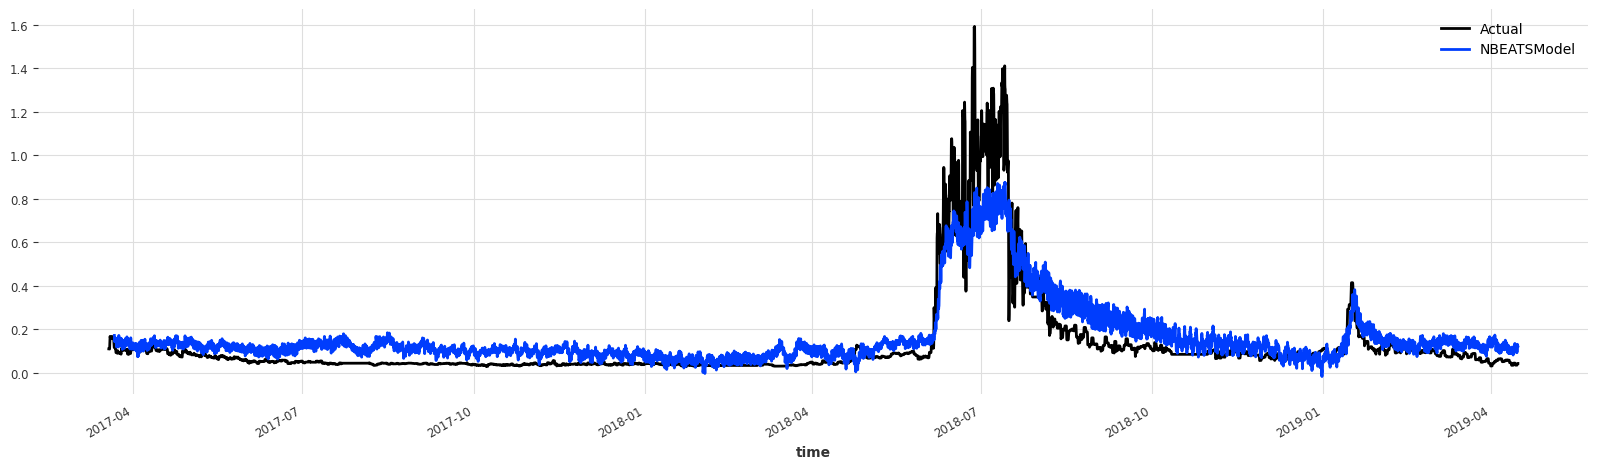

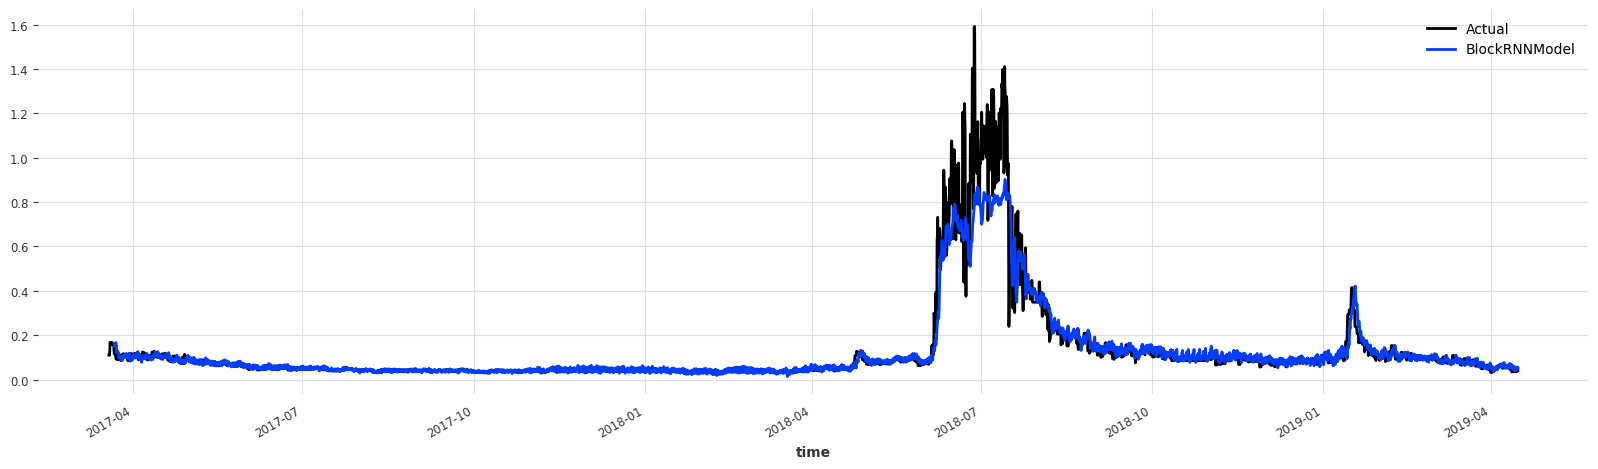

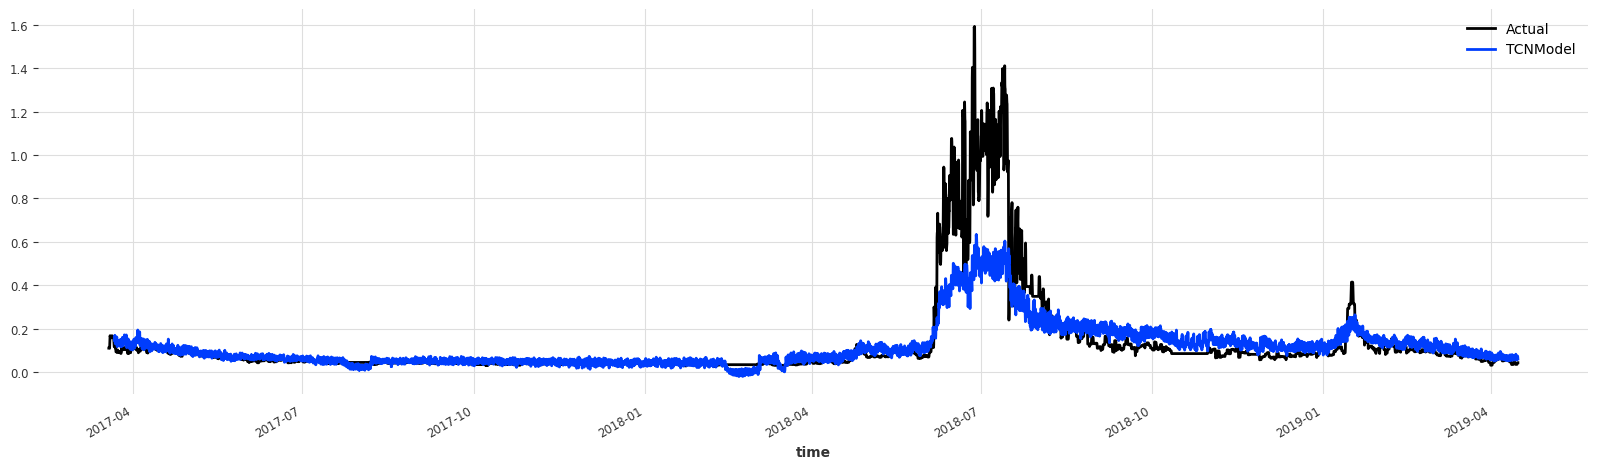

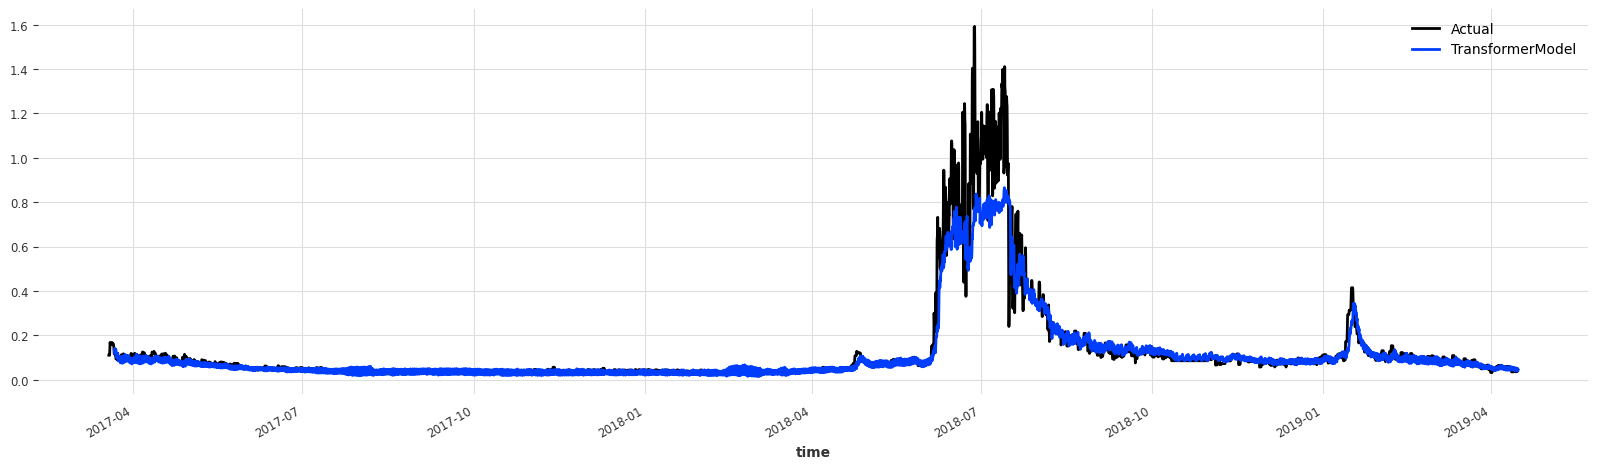

In [74]:
for model_name, model in models.items():
    print('Logging model ', model)
    logging(model)
